# Contexto

Você é o responsável por dados e análises no time de Relacionamento com o Cliente. Este time é responsável por cuidar dos nossos clientes, tirando todas as dúvidas e os ajudando a fazer melhor uso dos nossos produtos.

Nos últimos tempos tivemos alguns problemas e precisamos da sua ajuda para tomarmos as melhores decisões para melhor atender nossos clientes. 


### Questões

1.	Foi implementada no dia 1 de agosto uma funcionalidade nova no site do Ton que acredita que irá diminuir a quantidade de chamados recebidos. Avalie se a implementação teve um impacto estatisticamente relevante.

2.	Foi notado pelo nosso time que clientes recem credenciados possuem um comportamento específico em relação à quantidade de chamados realizados logo após seu credenciamento. Identifique e prepare alguma forma de visualizar essa diferença notada pelos agentes.

3.	Para conseguir melhorar a qualidade do nosso atendimento ao cliente, foi proposto que a alguns chamados tenham prioridade de atendimento. Levando em consideração o motivo dos chamados, como você estabeleceria essa prioridade da fila de espera? Sugestão: Proponha uma clusterização da base de clientes que julgue atender da melhor forma a necessidade apresentada.

4.	Escreva duas queries em SQL que retornem: 

i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.

ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias (por exemplo, para o dia 30/01, a query deve retornar a quantidade de chamados totais entre os dias 01/01 e 30/01)


5.	Questão de estudo livre: Como é esperado de um analista de dados, traga insights relevantes sobre pontos de atenção e possíveis melhorias que você identificou ao analisar ambas as bases de dados. Além disso faça pelo menos duas perguntas relacionadas aos dados que julgue relevantes para análise, você também pode sugerir outros dados para enriquecer os aqui disponibilizados.

### Imports

In [1]:
# Importando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlalchemy
from pandasql import sqldf
import re
import warnings
warnings.filterwarnings("ignore")

### Dicionário

In [2]:
dic_cases = pd.read_csv('dic_cases.csv')
dic_creds = pd.read_csv('dic_creds.csv')

In [3]:
dic_cases

,accountid,Chave primária da tabela
0,date_ref,Data do chamado
1,channelid,Canal do chamado (chat = 1; telefone = 2; e-ma...
2,waitingtime,Tempo de espera para atendimento (segundos)
3,missed,Flag de chamado atendido
4,pesquisa_de_satisfa_o__c,Flag de pesquisa de satisfação preenchida
5,assunto,Assunto do chamado
6,Id,Chave da tabela


In [4]:
dic_creds

,Coluna,Descrição
0,cred_date,Data de credenciamento
1,shipping_address_city,Endereço de entrega – cidade
2,shipping_address_state,Endereço de entrega – estado
3,max_machine,Produto adquirido
4,accountid,Chave secundária da tabela


# Análise de Dados

In [5]:
# Carregamento dos dados
df_cases = pd.read_csv('cases.csv')
df = df_cases.copy()
df_cred = pd.read_csv('creds.csv')
df2 = df_cred.copy()

In [6]:
# Visualização dos dados
df

,Unnamed: 0,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,Id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
...,...,...,...,...,...,...,...,...,...
126984,126984,0013j00002yi49FAAQ,2020-08-26,2.0,9.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002yi49FAAQ
126985,126985,0013j00002yi49FAAQ,2020-09-09,2.0,4.0,False,NaN,Produto:D195:Ativação,0013j00002yi49FAAQ
126986,126986,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Cadastro:Recredenciamento:Dúvidas,0013j00002yi49FAAQ
126987,126987,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002yi49FAAQ


In [7]:
# Visualização dos dados
df2

,Unnamed: 0,cred_date,shipping_address_city,shipping_address_state,max_machine,accountid
0,0,2020-04-18,Feira de Santana,BA,T1,NaN
1,1,2020-10-16,Bacuri,MA,T1,NaN
2,2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
4,4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
...,...,...,...,...,...,...
126984,126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


## Limpeza e Tratamento dos Dados

### Visualização dos Dados

In [8]:
# Primeiramente irei remover a coluna 'Unnamed: 0' de ambos datasets pois esta representa apenas o índice
df.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)
df2.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)

In [9]:
# Verificando o tamanho dos datasets
print(df.shape)
print(df2.shape)

(126989, 8)
(126989, 5)


In [10]:
# Informativo dos datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accountid                 77489 non-null  object 
 1   date_ref                  77489 non-null  object 
 2   channelid                 77489 non-null  float64
 3   waitingtime               77489 non-null  float64
 4   missed                    77489 non-null  object 
 5   pesquisa_de_satisfa_o__c  11585 non-null  object 
 6   assunto                   77489 non-null  object 
 7   Id                        77489 non-null  object 
dtypes: float64(2), object(6)
memory usage: 7.8+ MB


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   cred_date               126989 non-null  object
 1   shipping_address_city   126989 non-null  object
 2   shipping_address_state  126989 non-null  object
 3   max_machine             126989 non-null  object
 4   accountid               77489 non-null   object
dtypes: object(5)
memory usage: 4.8+ MB


In [12]:
# Renomeando as colunas
df.columns = ['id_conta','data','canal','tempo_espera','chamada_perdida','pesquisa_satisfacao','assunto','id']

In [13]:
# Renomeando as colunas
df2.columns = ['data_cred', 'endereco_entrega_cidade', 'endereco_entrega_estado', 'produto_adquirido', 'id_conta']

### Valores NaN

In [14]:
# Verificando os valores NaN
df.isna().sum()

id_conta                49500
data                    49500
canal                   49500
tempo_espera            49500
chamada_perdida         49500
pesquisa_satisfacao    115404
assunto                 49500
id                      49500
dtype: int64

In [15]:
df2.isna().sum()

data_cred                      0
endereco_entrega_cidade        0
endereco_entrega_estado        0
produto_adquirido              0
id_conta                   49500
dtype: int64

In [16]:
# Remover os registros onde todos os valores são NaN
df.dropna(axis = 0, how = 'all', inplace= True)
df.isna().sum()

id_conta                   0
data                       0
canal                      0
tempo_espera               0
chamada_perdida            0
pesquisa_satisfacao    65904
assunto                    0
id                         0
dtype: int64

In [17]:
# Visualizando os registros que temos valores NaN na variável 'pesquisa_satisfacao'
df[(df['pesquisa_satisfacao'].isna())]

,id_conta,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Produto:S920:Ativação,0013j00002z0CeEAAU
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002z0CeEAAU
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Logística:Envio de Cartão:Tracking,0013j00002zQgldAAC
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Pedido:Cancelamento:Outros,0013j00002zQgldAAC
...,...,...,...,...,...,...,...,...
126984,0013j00002yi49FAAQ,2020-08-26,2.0,9.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002yi49FAAQ
126985,0013j00002yi49FAAQ,2020-09-09,2.0,4.0,False,NaN,Produto:D195:Ativação,0013j00002yi49FAAQ
126986,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Cadastro:Recredenciamento:Dúvidas,0013j00002yi49FAAQ
126987,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002yi49FAAQ


In [18]:
# Verificando os valores que temos na variável 'pesquisa_satisfacao'
df[(df['pesquisa_satisfacao'].isna() == False)]['pesquisa_satisfacao'].value_counts()

Enviado        9996
Incrivel        899
Bom             425
Normal          112
NaoResolveu     107
Feliz            19
MalAtendido      16
Triste            6
Pessimo           3
Cansativo         2
Name: pesquisa_satisfacao, dtype: int64

In [19]:
# Vamos imputar o valor 'Sem_resposta'
df['pesquisa_satisfacao'] = df['pesquisa_satisfacao'].fillna('Sem_resposta')

In [20]:
df2

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2020-04-18,Feira de Santana,BA,T1,NaN
1,2020-10-16,Bacuri,MA,T1,NaN
2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
...,...,...,...,...,...
126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


In [21]:
# Irei remover os registros em que a coluna id_conta é NaN pois essa é uma informação primordial para identificação do cliente
df2 = df2[(df2['id_conta'].isnull() == False)]
df2

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
7,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
...,...,...,...,...,...
126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


In [22]:
# Por enquanto irei manter os registros onde o produto adquirido(máquina de cartão) é 'NONE'. Caso seja necessário, farei sua remoção posteriormente
df2['produto_adquirido'].value_counts()

T2      28569
T3      25693
T1      22625
NONE      602
Name: produto_adquirido, dtype: int64

### Removendo coluna

In [23]:
# Remover a coluna id ou id_conta do df pois ambas representam a mesma informação
df[(df['id_conta'] != df['id'])]

,id_conta,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id


In [24]:
df.pop('id_conta')

4         0013j00002z0CeEAAU
5         0013j00002z0CeEAAU
6         0013j00002z0CeEAAU
7         0013j00002zQgldAAC
8         0013j00002zQgldAAC
                 ...        
126984    0013j00002yi49FAAQ
126985    0013j00002yi49FAAQ
126986    0013j00002yi49FAAQ
126987    0013j00002yi49FAAQ
126988    0013j00002yi49FAAQ
Name: id_conta, Length: 77489, dtype: object

In [25]:
df.columns

Index(['data', 'canal', 'tempo_espera', 'chamada_perdida',
       'pesquisa_satisfacao', 'assunto', 'id'],
      dtype='object')

In [26]:
# Vou alterar a posição da coluna 'id' e colocar como primeira coluna
df = df[['id', 'data', 'canal', 'tempo_espera', 'chamada_perdida', 'pesquisa_satisfacao', 'assunto']]
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros


### Valores Duplicados

In [27]:
# Verificando registros duplicados
print(df.duplicated().sum())
print(df2.duplicated().sum())

0
46060


In [28]:
# Visualizandos os valores duplicados do df2
df2[(df2.duplicated() == True)]

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
9,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
10,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
...,...,...,...,...,...
126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


> Não irei remover esses registros duplicados pois pode acontecer de uma loja grande pedir diversas maquininhas para atender a sua loja.

### Convertendo a coluna 'data' para o tipo 'date'

In [29]:
# Verificando novamente qual 'type' está nossa variável 'data'
df['data'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data
Non-Null Count  Dtype 
--------------  ----- 
77489 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [30]:
# Transformando a variável 'data' para 'date' 
df['data'] = df['data'].astype('datetime64[ns]')
df['data'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data
Non-Null Count  Dtype         
--------------  -----         
77489 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 MB


In [31]:
# Verificando novamente qual 'type' está nossa variável 'data_cred'
df2['data_cred'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data_cred
Non-Null Count  Dtype 
--------------  ----- 
77489 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [32]:
# Transformando a variável 'data_cred' para 'date' 
df2['data_cred'] = df2['data_cred'].astype('datetime64[ns]')
df2['data_cred'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data_cred
Non-Null Count  Dtype         
--------------  -----         
77489 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 MB


In [33]:
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,Sem_resposta,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros


In [34]:
df2.head()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
7,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC


### Manipulação dos Dados

Vamos fazer outras manipulações que serão conveniente para posterior análise dos dados

In [35]:
# Irei atribuir strings na váriavel 'canal' para ficar de melhor entendimento
df['canal'] = np.where((df['canal'] == 1.0), 'Chat',
                 np.where((df['canal'] == 2.0), 'Telefone',
                 np.where((df['canal'] == 3.0), 'Email',
                 np.nan)))

In [36]:
# Aqui é possível verificar que todas as chamadas foram feitas via telefone
df['canal'].value_counts()

Telefone    77489
Name: canal, dtype: int64

In [37]:
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
4,0013j00002z0CeEAAU,2020-07-31,Telefone,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,Telefone,15.0,False,Sem_resposta,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,Telefone,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,Telefone,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,Telefone,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros


In [38]:
df2.head()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
7,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC


In [39]:
# Número de linhaas e coluna das tabelas
print(df.shape, df2.shape)

(77489, 7) (77489, 5)


In [40]:
# Todos os 'id' da tabela de chamadas estão presentes na tabela de credenciamento
df[(df['id'].isin(df2['id_conta']) == False)]

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto


### Resumo Estatístico

In [41]:
# Resumo estatístico dos datasets
df.describe()

,tempo_espera
count,77489.000000
mean,17.224767
std,78.520336
min,0.000000
25%,6.000000
50%,9.000000
75%,14.000000
max,7993.000000


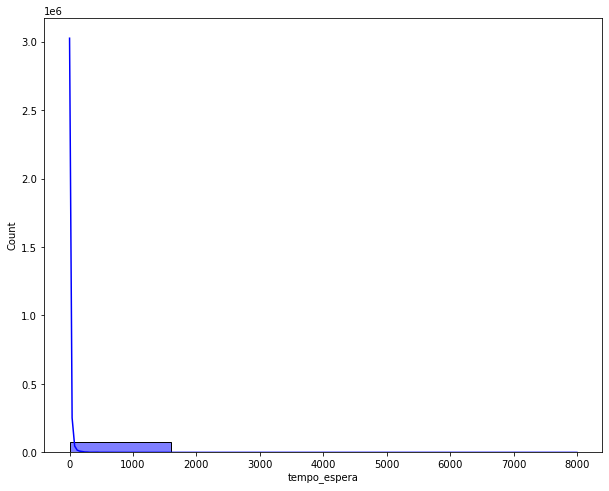

In [42]:
plt.figure(figsize=(10,8))

sns.histplot(data = df, x = df.tempo_espera, color = 'b',bins = 5, kde = True)
plt.show()

In [43]:
# Resumo estatistico das variáveis categoricas do df
df[['canal', 'chamada_perdida', 'pesquisa_satisfacao', 'assunto', 'id']].describe()

,canal,chamada_perdida,pesquisa_satisfacao,assunto,id
count,77489,77489,77489,77489,77489
unique,1,2,11,221,31429
top,Telefone,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas,0011L00002WeMWyQAN
freq,77489,77483,65904,5153,56


In [44]:
# Resumo estatístico df2
df2.describe()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
count,77489,77489,77489,77489,77489
unique,441,2757,27,4,31429
top,2020-09-01 00:00:00,São Paulo,SP,T2,0011L00002WeMWyQAN
freq,1274,6389,20056,28569,56
first,2019-07-24 00:00:00,NaN,NaN,NaN,NaN
last,2020-10-30 00:00:00,NaN,NaN,NaN,NaN


# Questão 1

1.	Foi implementada no dia 1 de agosto uma funcionalidade nova no site do Ton que acredita que irá diminuir a quantidade de chamados recebidos. Avalie se a implementação teve um impacto estatisticamente relevante.

Aqui irei verificar qual a média de registros nos meses a partir de Agosto e comparar com a média dos registros antes de Agosto.  
Também é possível que se faça uma comparação na satisfação e tempo de espera.

Importante verificar se há também um aumento no número de clientes, pois caso haja, o aumento do número de chamadas pode não representar um aumento real nas chamadas

Preciso saber a quantidade de chamados recebidos por cliente

In [45]:
# Ordenando o dataset por data (e aproveitando para ordernar o df2 também)
df = df.sort_values('data').reset_index(drop=True)
df2 = df2.sort_values('data_cred').reset_index(drop=True)
df.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:
2,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...
3,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido
4,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::


In [46]:
# Verificando se os ultimos registros realmente estão com as últimas datas
df.tail()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
77484,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...
77485,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...
77486,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação
77487,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS
77488,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...


In [47]:
# df_ago = df[(df.data >= '2020-08-01')]
# df_ago

In [48]:
q1 = df.copy()
q1['Mês'] = np.where((df['data'] >= '2020-02-01') & (df['data'] <= '2020-02-29'), 'Fevereiro',
            np.where((df['data'] >= '2020-03-01') & (df['data'] <= '2020-03-31'), 'Março',
            np.where((df['data'] >= '2020-04-01') & (df['data'] <= '2020-04-30'), 'Abril',
            np.where((df['data'] >= '2020-05-01') & (df['data'] <= '2020-05-31'), 'Maio',
            np.where((df['data'] >= '2020-06-01') & (df['data'] <= '2020-06-30'), 'Junho',
            np.where((df['data'] >= '2020-07-01') & (df['data'] <= '2020-07-31'), 'Julho',
            np.where((df['data'] >= '2020-08-01') & (df['data'] <= '2020-08-31'), 'Agosto',
            np.where((df['data'] >= '2020-09-01') & (df['data'] <= '2020-09-30'), 'Setembro',
            'Outubro'
            ))))))))
q11 = q1.copy() # será usado posteriormente

In [49]:
q1['dia'] = q1['data'].dt.strftime('%d')

In [50]:
q1.head()

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,Mês,dia
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,Fevereiro,23
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,Fevereiro,25
2,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,Fevereiro,26
3,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,Fevereiro,26
4,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,Fevereiro,26


In [51]:
grafico1 = q1.groupby(['Mês', 'dia'], sort=False).agg({'id':'count'}).reset_index(drop = False)
grafico1 = grafico1.rename(columns= {'id':'count'})
grafico1

,Mês,dia,count
0,Fevereiro,23,1
1,Fevereiro,25,1
2,Fevereiro,26,22
3,Fevereiro,27,31
4,Fevereiro,28,27
...,...,...,...
240,Outubro,25,208
241,Outubro,26,652
242,Outubro,27,627
243,Outubro,28,556


> Vamos desconsiderar os dados de Fevereiro visto que as chamadas começaram a ser registrado apenas no final do mês

In [52]:
grafico1 = grafico1[(grafico1['Mês'] != 'Fevereiro')]
grafico1

,Mês,dia,count
6,Março,01,11
7,Março,02,46
8,Março,03,41
9,Março,04,53
10,Março,05,46
...,...,...,...
240,Outubro,25,208
241,Outubro,26,652
242,Outubro,27,627
243,Outubro,28,556


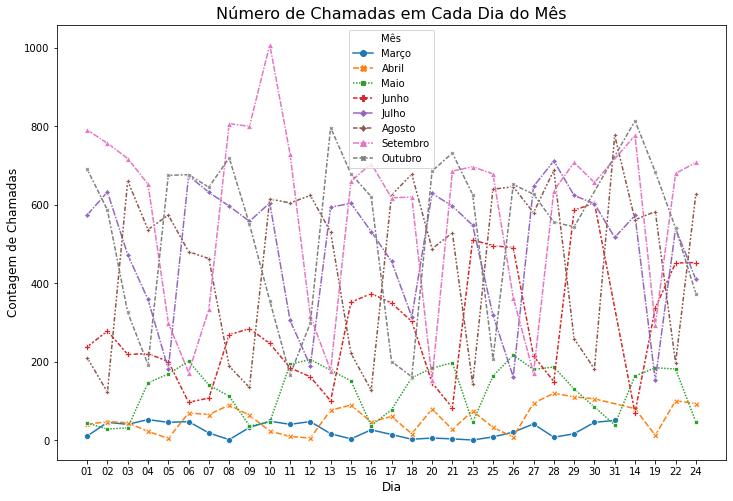

In [53]:
# Verificando se é possível observar uma relação do número de chamadas de acordo com o dia da semana 

# https://seaborn.pydata.org/generated/seaborn.lineplot.html
plt.figure(figsize=(12,8))

sns.lineplot(data = grafico1, x = 'dia', y = 'count', hue = 'Mês', style = 'Mês', markers = True)
plt.title('Número de Chamadas em Cada Dia do Mês', fontdict={'fontsize':16})
plt.xlabel('Dia', fontdict = {'fontsize': 12})
plt.ylabel('Contagem de Chamadas', fontdict = {'fontsize': 12})
plt.show()



> Não é possível notar um padrão no número de chamadas com base no dia da semana

In [54]:
# Verificar o Número de chamadas por Mês
grafico12 = q1.groupby(['Mês'], sort=False).agg({'id':'count'}).reset_index(drop = False)
grafico12 = grafico12.rename(columns= {'id':'count'})
grafico12

,Mês,count
0,Fevereiro,91
1,Março,708
2,Abril,1730
3,Maio,3978
4,Junho,8587
5,Julho,15318
6,Agosto,14305
7,Setembro,17381
8,Outubro,15391


> Podemos desconsiderar o mês de Fevereiro das Análises pois os registros começam ao final do mês. 

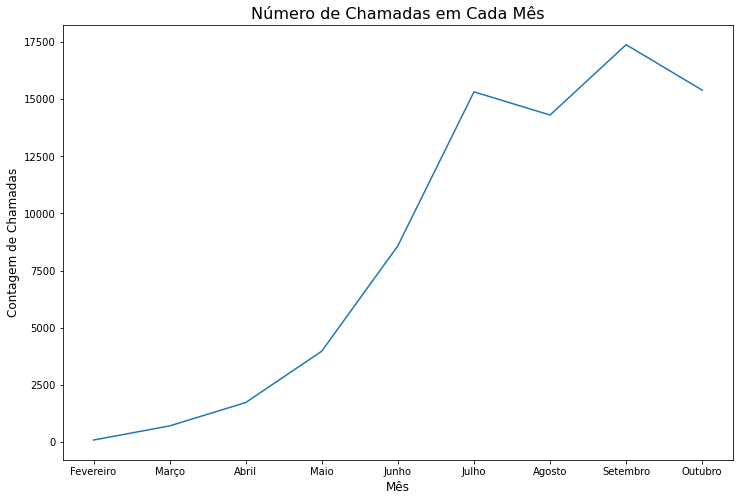

In [55]:

# Line plot -> Pode ser que apagar esse gráfico seja melhor
plt.figure(figsize=(12,8))

sns.lineplot(data = grafico12, x = 'Mês', y = 'count', markers = 'O')
plt.title('Número de Chamadas em Cada Mês', fontdict={'fontsize':16})
plt.xlabel('Mês', fontdict = {'fontsize': 12})
plt.ylabel('Contagem de Chamadas', fontdict = {'fontsize': 12})
plt.show()
plt.show()

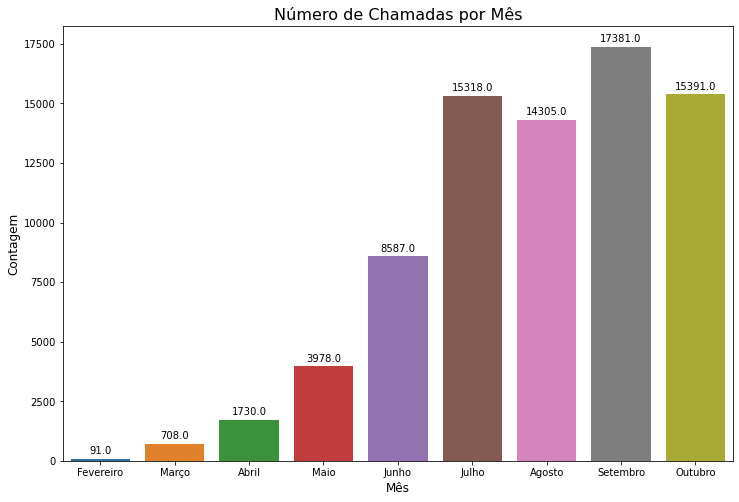

In [56]:
# Gráfico de barras que representa a quantidade de chamadas por Mês 
plt.figure(figsize=(12,8))

ax = sns.barplot(data = grafico12, x = 'Mês', y = 'count')
plt.title('Número de Chamadas por Mês', fontdict={'fontsize':16})
plt.xlabel('Mês', fontdict = {'fontsize': 12})
plt.ylabel('Contagem', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

In [57]:
grafico13 = grafico12.copy()
grafico13['mudanca'] = np.where((grafico13['Mês'] == 'Agosto') | (grafico13['Mês'] == 'Setembro') | (grafico13['Mês'] == 'Outubro'),'Pos Mudanca', 'Pre Mudanca')
grafico13

,Mês,count,mudanca
0,Fevereiro,91,Pre Mudanca
1,Março,708,Pre Mudanca
2,Abril,1730,Pre Mudanca
3,Maio,3978,Pre Mudanca
4,Junho,8587,Pre Mudanca
5,Julho,15318,Pre Mudanca
6,Agosto,14305,Pos Mudanca
7,Setembro,17381,Pos Mudanca
8,Outubro,15391,Pos Mudanca


In [58]:
# Vamos remover a linha referente a Fevereiro por ser um valor muito abaixo (há registro somente do final do mês em Fevereiro)
grafico13.drop(0, axis= 0, inplace= True)
grafico13

,Mês,count,mudanca
1,Março,708,Pre Mudanca
2,Abril,1730,Pre Mudanca
3,Maio,3978,Pre Mudanca
4,Junho,8587,Pre Mudanca
5,Julho,15318,Pre Mudanca
6,Agosto,14305,Pos Mudanca
7,Setembro,17381,Pos Mudanca
8,Outubro,15391,Pos Mudanca


In [59]:
grafico13 = grafico13.groupby('mudanca').agg({'count':'mean'}).reset_index(drop = False)
grafico13.columns = ['Mudanca', 'Media']
grafico13

,Mudanca,Media
0,Pos Mudanca,15692.333333
1,Pre Mudanca,6064.200000


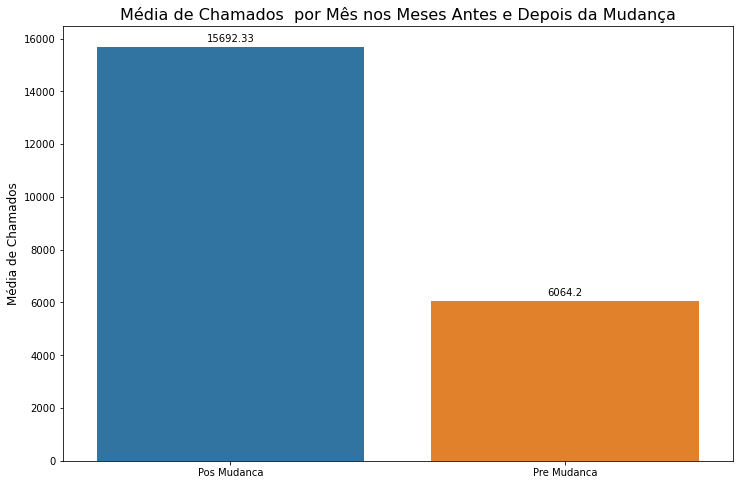

In [60]:
# Gráfico que mostra a média de chamadas antes e pós a mudança
plt.figure(figsize=(12,8))

ax = sns.barplot(x = grafico13['Mudanca'] , y = grafico13['Media'])
plt.title('Média de Chamados  por Mês nos Meses Antes e Depois da Mudança', fontdict={'fontsize':16})
plt.xlabel('')
plt.ylabel('Média de Chamados', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

> A mundaça não parece ter surtido efeito, visto que o número de chamadas mensal aumentou após as mudanças feitas.  
> No entanto, apesar de improvável devido ao pequeno intervalo de tempo, esse alto número de chamadas pode ter sido causada por um aumento no número de clientes.

In [61]:
df2.head()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2019-07-24,Betim,MG,T1,0011L00002Wd777QAB
1,2019-07-24,Mossoró,RN,T1,0011L00002Wd78eQAB
2,2019-07-24,Rio de Janeiro,RJ,T1,0011L00002WdAxkQAF
3,2019-07-24,Maricá,RJ,NONE,0011L00002Wd7AkQAJ
4,2019-07-24,São Paulo,SP,T1,0011L00002Wd78PQAR


In [62]:
q1 = df2.copy()
q1.drop_duplicates('id_conta', inplace = True)
q1

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2019-07-24,Betim,MG,T1,0011L00002Wd777QAB
1,2019-07-24,Mossoró,RN,T1,0011L00002Wd78eQAB
2,2019-07-24,Rio de Janeiro,RJ,T1,0011L00002WdAxkQAF
3,2019-07-24,Maricá,RJ,NONE,0011L00002Wd7AkQAJ
4,2019-07-24,São Paulo,SP,T1,0011L00002Wd78PQAR
...,...,...,...,...,...
77476,2020-10-30,Embu-Guaçu,SP,T1,0013j000030FWnRAAW
77482,2020-10-30,Goiânia,GO,T2,0013j000030EO1KAAW
77483,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77485,2020-10-30,Placas,PA,T3,0013j000030SNX6AAO


In [63]:
apos_agosto = q1[(q1['data_cred'] > "2020-08-01")]
apos_agosto

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
47759,2020-08-02,Serra,ES,T3,0013j00002z1HU9AAM
47760,2020-08-02,São Lourenço da Mata,PE,T3,0013j00002z1HW5AAM
47761,2020-08-02,São Paulo,SP,T3,0013j00002z1GQzAAM
47762,2020-08-02,Fortaleza,CE,T2,0013j00002z1GuLAAU
47763,2020-08-02,Blumenau,SC,T3,0013j00002z1HAEAA2
...,...,...,...,...,...
77476,2020-10-30,Embu-Guaçu,SP,T1,0013j000030FWnRAAW
77482,2020-10-30,Goiânia,GO,T2,0013j000030EO1KAAW
77483,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77485,2020-10-30,Placas,PA,T3,0013j000030SNX6AAO


In [64]:
entre_marco_agosto = q1[(q1['data_cred'] < "2020-08-01") & (q1['data_cred'] > "2020-03-01")]
entre_marco_agosto

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
4152,2020-03-02,Silveira Martins,RS,T1,0011L00002ebJPxQAM
4153,2020-03-02,São Gonçalo,RJ,T3,0011L00002deKPZQA2
4154,2020-03-02,Rio de Janeiro,RJ,T1,0011L00002ebJObQAM
4157,2020-03-02,Campina Grande,PB,T3,0011L00002ebL2lQAE
4158,2020-03-02,Indaial,SC,T3,0011L00002ebD3CQAU
...,...,...,...,...,...
47458,2020-07-31,Louveira,SP,T3,0013j00002z0wpqAAA
47460,2020-07-31,Vila Velha,ES,T3,0013j00002z0nq5AAA
47461,2020-07-31,São Paulo,SP,T2,0013j00002z15kiAAA
47463,2020-07-31,Manaus,AM,T2,0013j00002z0hTAAAY


In [65]:
apos_agosto['id_conta'].duplicated().sum()

0

In [66]:
print(f'Média de contas credenciadas criadas por mês nos meses entre Março e Agosto {len(entre_marco_agosto)/5}')
print(f'Média de contas credenciadas por mês nos meses entre Agosto e Outubro {len(apos_agosto)/3}')

Média de contas credenciadas criadas por mês nos meses entre Março e Agosto 3130.0
Média de contas credenciadas por mês nos meses entre Agosto e Outubro 4649.0


In [67]:
print(f'Aumento percentual no número de credenciamento mensal dos Meses de Março-Julho para Agosto-Outubro: {round(((len(apos_agosto)/3-len(entre_marco_agosto)/5))/(len(entre_marco_agosto)/5)*100,2)}%')

Aumento percentual no número de credenciamento mensal dos Meses de Março-Julho para Agosto-Outubro: 48.53%


In [68]:
print(f'Aumento percentual no número de chamadas mensal dos Meses de Março-Julho para Agosto-Outubro: {round((grafico13.Media[0] - (grafico13.Media[1])) / (grafico13.Media[1]) * 100, 2)}%')

Aumento percentual no número de chamadas mensal dos Meses de Março-Julho para Agosto-Outubro: 158.77%


> Houve um aumento de aproximadamente 48.5% no número de credenciamentos por mês nos meses após Agosto.  
> Se compararmos o número de chamadas dos meses de Agosto a Outubro com o número de chamadas de Março a Julho tivemos um aumento de aproximadamente 158.8%. Portanto, continuamos a concluir que não houve uma diminuição no número de chamdas, uma vez que o número de chamadas aumentou mais que três vezes mais que o número de novos credenciamentos. O que pode ter acontecido é que clientes antigos estejam fazendo chamadas após a mudança ainda, o que causaria mudanças na nossa análise. Irei verificar abaixo.  
> Obs: Esta afirmação parte da hipótese de que todos os registros credenciamentos estão contidos na tabela df2

Extrair a média de chamdas por clientes aantes e após a mudança no site.

In [69]:
# q11 foi definino linhas atrás
q11['mudanca'] = np.where((q11['Mês'] == 'Agosto') | (q11['Mês'] == 'Setembro') | (q11['Mês'] == 'Outubro'),'Pos Mudanca', 'Pre Mudanca')

In [70]:
q111 = q11.groupby(['id', 'mudanca']).agg({'id':'count'})
q111.columns =['contagem']
q111.reset_index(drop=False, inplace= True)
# q111 = q111.groupby('mudanca').agg({'contagem':'sum'})
q111

,id,mudanca,contagem
0,0011L00002BkMyMQAV,Pre Mudanca,3
1,0011L00002Cj0AdQAJ,Pos Mudanca,2
2,0011L00002EIYHiQAP,Pre Mudanca,1
3,0011L00002EKxMcQAL,Pos Mudanca,1
4,0011L00002EKxMcQAL,Pre Mudanca,2
...,...,...,...
35997,0013j000030SNX6AAO,Pos Mudanca,1
35998,0014100001cPlR3AAK,Pre Mudanca,1
35999,0014100001fNwQfAAK,Pre Mudanca,3
36000,0014100001hbFl3AAE,Pre Mudanca,4


In [71]:
# Tivemos 22720 clientes fazendo chamadas Pós Mudança
q111[(q111.mudanca == 'Pos Mudanca')]

,id,mudanca,contagem
1,0011L00002Cj0AdQAJ,Pos Mudanca,2
3,0011L00002EKxMcQAL,Pos Mudanca,1
5,0011L00002IXd2mQAD,Pos Mudanca,1
7,0011L00002JXLgFQAX,Pos Mudanca,1
9,0011L00002K45IUQAZ,Pos Mudanca,3
...,...,...,...
35993,0013j000030FakSAAS,Pos Mudanca,1
35994,0013j000030FfeRAAS,Pos Mudanca,1
35995,0013j000030FjFBAA0,Pos Mudanca,1
35996,0013j000030FjRIAA0,Pos Mudanca,2


In [72]:
# Tivemos 13282 clientes fazendo chamadas Pré Mudança
q111[(q111.mudanca == 'Pre Mudanca')]

,id,mudanca,contagem
0,0011L00002BkMyMQAV,Pre Mudanca,3
2,0011L00002EIYHiQAP,Pre Mudanca,1
4,0011L00002EKxMcQAL,Pre Mudanca,2
6,0011L00002JXHZKQA5,Pre Mudanca,7
8,0011L00002K2dxaQAB,Pre Mudanca,2
...,...,...,...
23579,0013j00002z1AyaAAE,Pre Mudanca,1
35998,0014100001cPlR3AAK,Pre Mudanca,1
35999,0014100001fNwQfAAK,Pre Mudanca,3
36000,0014100001hbFl3AAE,Pre Mudanca,4


In [73]:
q111 = q111.groupby('mudanca').agg({'contagem':'sum'})
q111


,contagem
mudanca,
Pos Mudanca,47077
Pre Mudanca,30412


>Se pegarmos a quantidade de clientes que fizeram chamadas antes da mudança, somarmos o número de chamadas feitas por eles e fizermos a divisão do número de chamadas pelo número de clientes, tivemos uma taxa 3.5 chamadas por clientes, enquanto fazendo a mesma coisa após mudança, tivemos uma taxa de 2.07 chamadas por clientes. Conclui-se  então houve sim um diminuição significativa (de 69%) no número de chamadas após a mudança no site.

# Questão 2

2.	Foi notado pelo nosso time que clientes recem credenciados possuem um comportamento específico em relação à quantidade de chamados realizados logo após seu credenciamento. Identifique e prepare alguma forma de visualizar essa diferença notada pelos agentes.

Irei comparar apenas os registros que tem chamadas após o credenciamento

In [74]:
df

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:
2,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...
3,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido
4,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::
...,...,...,...,...,...,...,...
77484,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...
77485,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...
77486,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação
77487,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS


In [75]:
df2

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2019-07-24,Betim,MG,T1,0011L00002Wd777QAB
1,2019-07-24,Mossoró,RN,T1,0011L00002Wd78eQAB
2,2019-07-24,Rio de Janeiro,RJ,T1,0011L00002WdAxkQAF
3,2019-07-24,Maricá,RJ,NONE,0011L00002Wd7AkQAJ
4,2019-07-24,São Paulo,SP,T1,0011L00002Wd78PQAR
...,...,...,...,...,...
77484,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77485,2020-10-30,Placas,PA,T3,0013j000030SNX6AAO
77486,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77487,2020-10-30,Almirante Tamandaré,PR,T2,0013j00002yLMR1AAO


In [76]:
df3 = pd.merge(df, df2[[ 'id_conta', 'data_cred', 'produto_adquirido']], left_on = 'id', right_on= 'id_conta', how = 'left')
df3

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB,2019-10-28,T1
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
2,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
3,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB,2019-07-28,NONE
4,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1
...,...,...,...,...,...,...,...,...,...,...
326950,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326951,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326952,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j00002zeAEbAAM,2020-09-02,T3
326953,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j00002zeAEbAAM,2020-09-02,T3


In [77]:
# Verificando se está gerando valores duplicados (devido aos pedidos de mais de uma máquininha para uma loja)
df3[(df3.duplicated() == True)]

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
2,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
5,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1
8,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,2020-01-29,T1
9,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,2020-01-29,T1
10,0011L00002cptcAQAQ,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,2020-01-29,T1
...,...,...,...,...,...,...,...,...,...,...
326949,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326950,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326951,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3
326953,0013j00002zeAEbAAM,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j00002zeAEbAAM,2020-09-02,T3


In [78]:
# Irei remover esses registros pois não estamos interessados no momento na informação de quantas máquininhas um cliente pediu
df3 = df3[(df3.duplicated() == False)]
df3

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB,2019-10-28,T1
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
3,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB,2019-07-28,NONE
4,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1
6,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,0011L00002We7cjQAB,2019-08-03,NONE
...,...,...,...,...,...,...,...,...,...,...
326938,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002ymhaoAAA,2020-06-30,T2
326943,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...,0013j00002ynvv0AAA,2020-07-07,T2
326944,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação,0013j00002zfqezAAA,2020-09-15,T2
326946,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3


In [79]:
# Filtrar as chamadas que ocorrem em ATÉ UMA(podemos mudar pra testar) semana (7 dias) após a data do credenciamento do cliente
q2 = df3[(df3['data'] - df3['data_cred'] <= np.timedelta64(14,'D'))]
q2

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3
15,0011L00002dcq90QAA,2020-02-26,Telefone,13.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Transfe...,0011L00002dcq90QAA,2020-02-19,T1
31,0011L00002dcYFoQAM,2020-02-26,Telefone,10.0,False,Sem_resposta,Produto:Pinpad:Dúvidas pinpad,0011L00002dcYFoQAM,2020-02-18,T1
39,0011L00002QaBXDQA3,2020-02-26,Telefone,5.0,False,Enviado,Logística:OS:Tracking de OS,0011L00002QaBXDQA3,2020-07-03,T3
43,0011L00002ddcp9QAA,2020-02-26,Telefone,9.0,False,Enviado,Produto:Simulação de vendas:,0011L00002ddcp9QAA,2020-02-20,T3
...,...,...,...,...,...,...,...,...,...,...
326906,0013j000030EFmWAAW,2020-10-29,Telefone,12.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j000030EFmWAAW,2020-10-23,T2
326911,0013j000030D9XtAAK,2020-10-29,Telefone,19.0,False,Sem_resposta,Logística:OS:Ineficiência,0013j000030D9XtAAK,2020-10-20,T1
326935,0013j000030DBflAAG,2020-10-29,Telefone,13.0,False,Sem_resposta,Logística:OS:Ineficiência,0013j000030DBflAAG,2020-10-21,T1
326936,0013j000030EFnAAAW,2020-10-29,Telefone,7.0,False,Sem_resposta,Pedido:Cancelamento:Outros,0013j000030EFnAAAW,2020-10-24,T3


In [80]:
# Talvez seja melhor criar uma coluna binária que indique se a chamada foi feita antes ou dps de um mês de credenciamento (1 -> chamadas de clientes recém credenciados , 0 -> chamados de clientes credenciados a mais de 1 mês)
# df3['chamadas_primeiro_mes'] = np.where((df3['data'] - df3['data_cred'] < np.timedelta64(1, 'M')), 1, 0)

In [81]:
# Estou Criando uma nova coluna 'chamadas_7_dias' para identificar se a chamada for feita logo após o credenciamento do cliente ou não
df3['chamadas_7_dias'] = np.where((df3['data'] < df3['data_cred']), 'Chamadada Sem Credenciamento',
                                np.where((df3['data'] - df3['data_cred'] <= np.timedelta64(7, 'D')), 'Chamada Com Menos de 1 Semana de Credenciamento' ,
                                np.where((df3['data'] - df3['data_cred'] >= np.timedelta64(7, 'D')), 'Chamada Com Mais de 1 Semana de Credenciamento', np.nan)))


In [82]:
df3.value_counts()

id                  data        canal     tempo_espera  chamada_perdida  pesquisa_satisfacao  assunto                                         id_conta            data_cred   produto_adquirido  chamadas_7_dias                                
0011L00002BkMyMQAV  2020-05-27  Telefone  109.0         False            Enviado              Cadastro:Alteração de dados:Nome fantasia       0011L00002BkMyMQAV  2020-05-21  T2                 Chamada Com Menos de 1 Semana de Credenciamento    1
0013j00002z1LGrAAM  2020-08-04  Telefone  3.0           False            Sem_resposta         Logística:OS:Tracking de OS                     0013j00002z1LGrAAM  2020-08-04  T2                 Chamada Com Menos de 1 Semana de Credenciamento    1
0013j00002z1L2yAAE  2020-08-09  Telefone  3.0           False            Sem_resposta         Produto:Cartão pré-pago:Dúvidas                 0013j00002z1L2yAAE  2020-08-04  T3                 Chamada Com Menos de 1 Semana de Credenciamento    1
                     

In [83]:
df3

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido,chamadas_7_dias
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB,2019-10-28,T1,Chamada Com Mais de 1 Semana de Credenciamento
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3,Chamada Com Mais de 1 Semana de Credenciamento
3,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB,2019-07-28,NONE,Chamada Com Mais de 1 Semana de Credenciamento
4,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1,Chamada Com Mais de 1 Semana de Credenciamento
6,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,0011L00002We7cjQAB,2019-08-03,NONE,Chamada Com Mais de 1 Semana de Credenciamento
...,...,...,...,...,...,...,...,...,...,...,...
326938,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002ymhaoAAA,2020-06-30,T2,Chamada Com Mais de 1 Semana de Credenciamento
326943,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...,0013j00002ynvv0AAA,2020-07-07,T2,Chamada Com Mais de 1 Semana de Credenciamento
326944,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação,0013j00002zfqezAAA,2020-09-15,T2,Chamada Com Mais de 1 Semana de Credenciamento
326946,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3,Chamada Com Menos de 1 Semana de Credenciamento


In [84]:
# Aqui já podemos ver que as chamadas do primeiro mês representam mais da metade do restante das chamadas
q2 = df3.groupby(['chamadas_7_dias']).agg({'id': 'count'})
q2

,id
chamadas_7_dias,
Chamada Com Mais de 1 Semana de Credenciamento,56697
Chamada Com Menos de 1 Semana de Credenciamento,17024
Chamadada Sem Credenciamento,3768


In [85]:
# Irei remover as chamadas Sem Credenciamento para fins de análise
q2 = q2.iloc[0:2]
q2

,id
chamadas_7_dias,
Chamada Com Mais de 1 Semana de Credenciamento,56697
Chamada Com Menos de 1 Semana de Credenciamento,17024


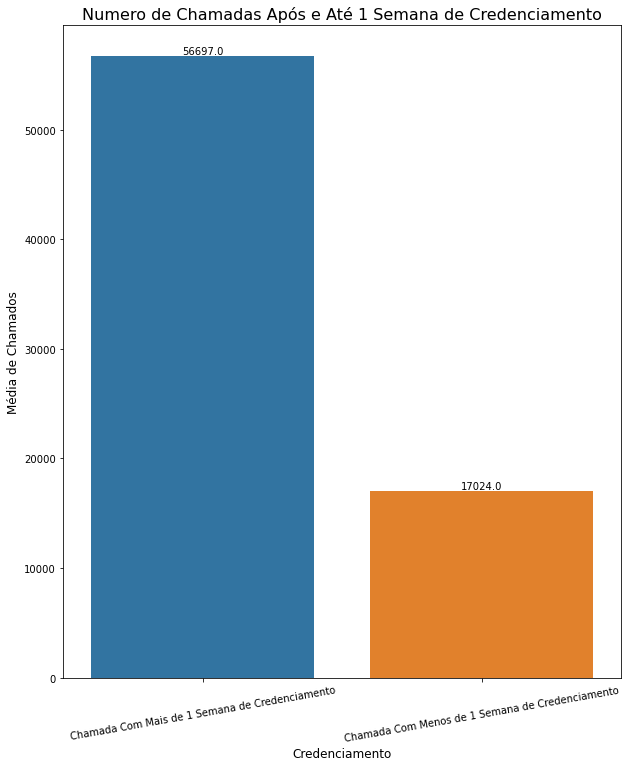

In [86]:
# Plot
plt.figure(figsize=(10,12))

ax = sns.barplot(x = q2.index , y = q2['id'])
plt.title('Numero de Chamadas Após e Até 1 Semana de Credenciamento', fontdict={'fontsize':16})
plt.xlabel('Credenciamento', fontdict = {'fontsize': 12})
plt.xticks(rotation=10)
plt.ylabel('Média de Chamados', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

In [87]:
# Irei plotar as chamadas ao longo das datas
q2 = df3.groupby(['chamadas_7_dias', 'data']).agg({'id': 'count'}).reset_index(drop = False)
q2 = q2[(q2['chamadas_7_dias'] != 'Chamadada Sem Credenciamento')]
q21 = q2[(q2['chamadas_7_dias'] == 'Chamada Com Mais de 1 Semana de Credenciamento')]
q22 = q2[(q2['chamadas_7_dias'] != 'Chamada Com Mais de 1 Semana de Credenciamento')]
q2

,chamadas_7_dias,data,id
0,Chamada Com Mais de 1 Semana de Credenciamento,2020-02-23,1
1,Chamada Com Mais de 1 Semana de Credenciamento,2020-02-25,1
2,Chamada Com Mais de 1 Semana de Credenciamento,2020-02-26,18
3,Chamada Com Mais de 1 Semana de Credenciamento,2020-02-27,23
4,Chamada Com Mais de 1 Semana de Credenciamento,2020-02-28,24
...,...,...,...
477,Chamada Com Menos de 1 Semana de Credenciamento,2020-10-25,21
478,Chamada Com Menos de 1 Semana de Credenciamento,2020-10-26,79
479,Chamada Com Menos de 1 Semana de Credenciamento,2020-10-27,110
480,Chamada Com Menos de 1 Semana de Credenciamento,2020-10-28,129


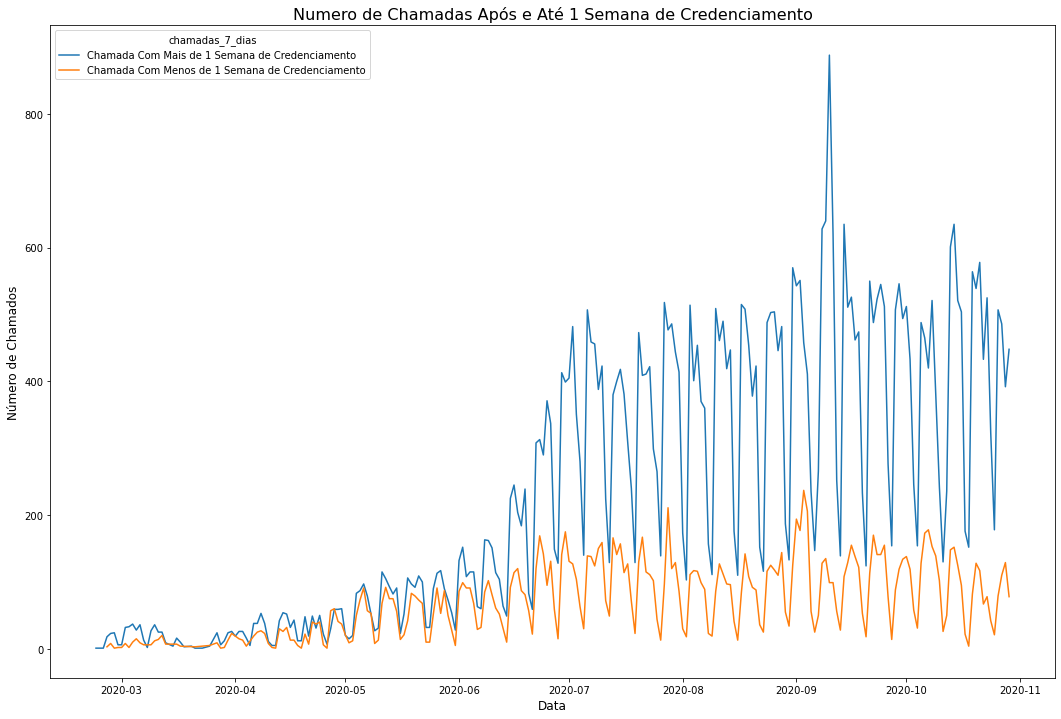

In [88]:
# eixo x data, eixo y count, hue = chamada_7_dias
plt.figure(figsize=(18,12))

sns.lineplot(x=q2['data'], y = q2.id, hue = q2['chamadas_7_dias'])
plt.title('Numero de Chamadas Após e Até 1 Semana de Credenciamento', fontdict={'fontsize':16})
plt.xlabel('Data', fontdict = {'fontsize': 12})
plt.ylabel('Número de Chamados', fontdict = {'fontsize': 12})
plt.show()

Abaixo vou calcular de outra maneira. ao invés de usar números absolutos como feito acima, irei ajustar para termos um contador por semana, dess maneira conseguiremos comparar mais própriamente com a contagem após 1 semana

In [89]:
# Estou Criando uma nova coluna 'chamadas_7_dias' para identificar se a chamada for feita logo após o credenciamento do cliente ou não
df3['chamadas_7_dias'] = np.where((df3['data'] < df3['data_cred']), 'Chamadada Sem Credenciamento',
                                np.where((df3['data'] - df3['data_cred'] <= np.timedelta64(7, 'D')), 'Chamada Com Menos de 1 Semana de Credenciamento' ,
                                np.where((df3['data'] - df3['data_cred'] <= np.timedelta64(105, 'D')), 'Chamada Com Mais de 1 Semana de Credenciamento', np.nan))) # depois precisarei dividir o contador por 14 para termos o valor por semana


In [90]:
df3.chamadas_7_dias.value_counts()

Chamada Com Mais de 1 Semana de Credenciamento     49054
Chamada Com Menos de 1 Semana de Credenciamento    17024
nan                                                 7643
Chamadada Sem Credenciamento                        3768
Name: chamadas_7_dias, dtype: int64

In [91]:
q2 = df3.groupby(['chamadas_7_dias']).agg({'id': 'count'}).reset_index(drop=False)
q2 = q2.iloc[:2] # Estou retirando os valores que
q2.id[0] = q2.id[0]/14 # Aqui estou dividindo por 14 pois estamos usando 140 dias, que equivale a 14 semanas. Dessa maneira podemos comparar por semana
q2

,chamadas_7_dias,id
0,Chamada Com Mais de 1 Semana de Credenciamento,3503.857143
1,Chamada Com Menos de 1 Semana de Credenciamento,17024.000000


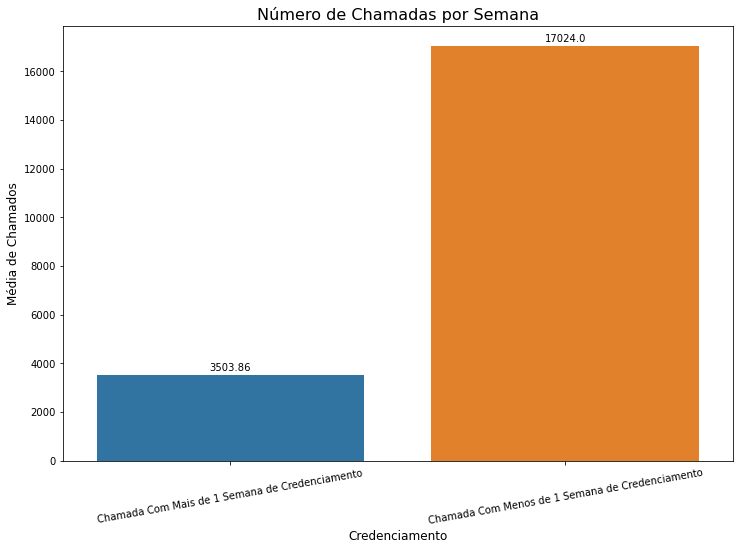

In [92]:
# Plot
plt.figure(figsize=(12,8))

ax = sns.barplot(x = q2.chamadas_7_dias , y = q2['id'])
plt.title('Número de Chamadas por Semana', fontdict={'fontsize':16})
plt.xlabel('Credenciamento', fontdict = {'fontsize': 12})
plt.xticks(rotation=10)
plt.ylabel('Média de Chamados', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

Farei o mesmo que acima, mas agora utilizando Mês

In [93]:
# Estou Criando uma nova coluna 'chamadas_7_dias' para identificar se a chamada for feita logo após o credenciamento do cliente ou não
df3['chamada_mes'] = np.where((df3['data'] < df3['data_cred']), 'Chamadada Sem Credenciamento',
                                np.where((df3['data'] - df3['data_cred'] <= np.timedelta64(1, 'M')), 'Chamada Com Menos de 1 Mês de Credenciamento' ,
                                np.where((df3['data'] - df3['data_cred'] <= np.timedelta64(4, 'M')), 'Chamada Com Mais de 1 Mês de Credenciamento', np.nan))) # depois precisarei dividir o contador por 3 para termos o valor por mes

In [94]:
df3.chamada_mes.value_counts()


Chamada Com Menos de 1 Mês de Credenciamento    46594
Chamada Com Mais de 1 Mês de Credenciamento     20966
nan                                              6161
Chamadada Sem Credenciamento                     3768
Name: chamada_mes, dtype: int64

In [95]:
df3

,id,data,canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id_conta,data_cred,produto_adquirido,chamadas_7_dias,chamada_mes
0,0011L00002ZbpnlQAB,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB,2019-10-28,T1,nan,Chamada Com Mais de 1 Mês de Credenciamento
1,0011L00002dbBg5QAE,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,2020-02-12,T3,Chamada Com Mais de 1 Semana de Credenciamento,Chamada Com Menos de 1 Mês de Credenciamento
3,0011L00002WdgbcQAB,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB,2019-07-28,NONE,nan,nan
4,0011L00002WdJgjQAF,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,2019-07-25,T1,nan,nan
6,0011L00002We7cjQAB,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,0011L00002We7cjQAB,2019-08-03,NONE,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
326938,0013j00002ymhaoAAA,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002ymhaoAAA,2020-06-30,T2,nan,Chamada Com Mais de 1 Mês de Credenciamento
326943,0013j00002ynvv0AAA,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...,0013j00002ynvv0AAA,2020-07-07,T2,nan,Chamada Com Mais de 1 Mês de Credenciamento
326944,0013j00002zfqezAAA,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação,0013j00002zfqezAAA,2020-09-15,T2,Chamada Com Mais de 1 Semana de Credenciamento,Chamada Com Mais de 1 Mês de Credenciamento
326946,0013j000030CkBtAAK,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK,2020-10-24,T3,Chamada Com Menos de 1 Semana de Credenciamento,Chamada Com Menos de 1 Mês de Credenciamento


In [96]:
q2 = df3.groupby(['chamada_mes']).agg({'id': 'count'}).reset_index(drop=False)
q2
q2 = q2.iloc[:2]
q2.id[0] = q2.id[0]/3 # Aqui estou dividindo por 3 pois estamos usando 3 meses. Dessa maneira podemos comparar por mês
q2

,chamada_mes,id
0,Chamada Com Mais de 1 Mês de Credenciamento,6988.666667
1,Chamada Com Menos de 1 Mês de Credenciamento,46594.000000


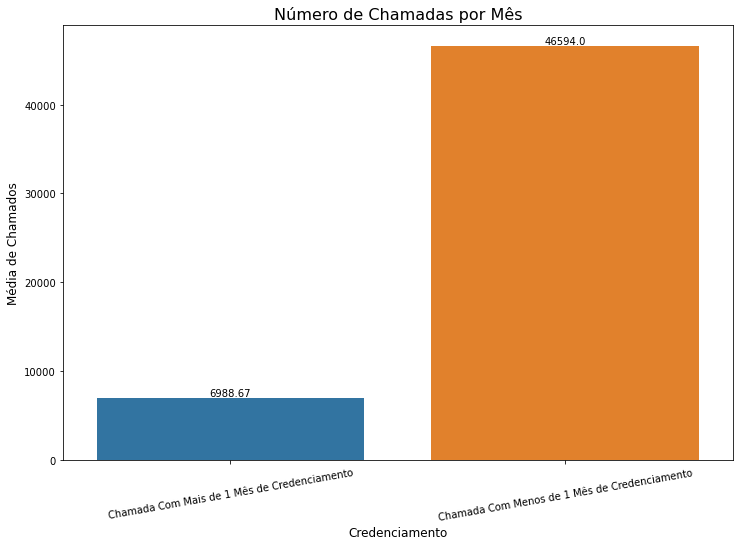

In [97]:
# Plot
plt.figure(figsize=(12,8))

ax = sns.barplot(x = q2.chamada_mes , y = q2['id'])
plt.title('Número de Chamadas por Mês', fontdict={'fontsize':16})
plt.xlabel('Credenciamento', fontdict = {'fontsize': 12})
plt.xticks(rotation=10)
plt.ylabel('Média de Chamados', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

> Conclusão: Quando comparado com números relativos, vemos que clientes recem credenciados tendem a fazer mais chamadas que clintes mais antigos. Isso faz total sentido, visto que novos clientes costumam ter mais dúvidas e precisam de mais suporte da empresa.

# Questão 3

3.	Para conseguir melhorar a qualidade do nosso atendimento ao cliente, foi proposto que a alguns chamados tenham prioridade de atendimento. Levando em consideração o motivo dos chamados, como você estabeleceria essa prioridade da fila de espera? Sugestão: Proponha uma clusterização da base de clientes que julgue atender da melhor forma a necessidade apresentada.

In [98]:
df.assunto.value_counts()

Produto:Cartão pré-pago:Dúvidas                                  5153
Logística:OS:Tracking de OS                                      4947
Aplicativo:Dúvidas funcionalidades App:Transferência bancária    4243
Transferência de saldo:Conta bancária:Problema                   2870
Produto:Modelo de recebimento:                                   2488
                                                                 ... 
Transferência de saldo:Cartão:Funcionalidade                        1
Aplicativo:Cartões:                                                 1
Feedback do cliente:Máquina:                                        1
Cadastro::                                                          1
Risco:Bloqueio:                                                     1
Name: assunto, Length: 221, dtype: int64

In [99]:
df4 = df.copy()
df4['tag_assunto'] = np.nan

for i in range(0, len(df4)):
    df4['tag_assunto'][i] = df4['assunto'][i].partition(':')[0]

In [100]:
df4['tag_assunto'].value_counts()

Produto                   22182
Aplicativo                20507
Logística                 15583
Cadastro                   6310
Pedido                     3266
Transferência de saldo     3013
Transação                  2265
Feedback do cliente        1205
Bandeira                   1061
Outros                     1056
Incidente                   486
Bandeiras                   230
Risco                       162
                            106
Telecom                      36
Comunicados                  21
Name: tag_assunto, dtype: int64

In [101]:
x=0
y=0
for i in range(0, len(df4['tag_assunto'].value_counts())):
    if i <= 2:
        x += int(df4['tag_assunto'].value_counts()[i])
    else:
        y += int(df4['tag_assunto'].value_counts()[i])
        
print(x)
print(y)
percentage = ((x/(x+y)* 100))
print(f'As chamadas sobre Produto, Aplicativo e Logística representam {round(percentage, 2)}% do total de chamadas.')

58272
19217
As chamadas sobre Produto, Aplicativo e Logística representam 75.2% do total de chamadas.


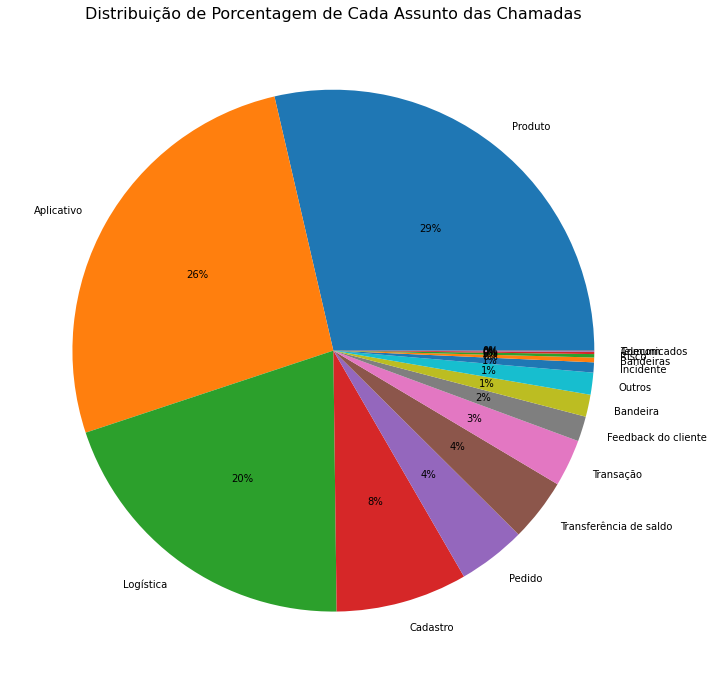

In [102]:
# Plot

plt.figure(figsize=(16,12))


plt.pie(x = df4['tag_assunto'].value_counts(), labels = df4['tag_assunto'].value_counts().index, autopct='%.0f%%')
plt.title('Distribuição de Porcentagem de Cada Assunto das Chamadas', fontdict={'fontsize': 16})
plt.show()

In [103]:
for i in df4['tag_assunto'].unique():
    print(df4[(df4['tag_assunto'] == str(i))]['assunto'].sample(5))
# Não é possível visualizar tudo de uma vez

9157                             Produto:S920:Ativação
66586                   Produto:Modelo de recebimento:
39546    Produto:S920:Falha de Conexão - não revertido
9471     Produto:D195:Falha de Conexão - não revertido
57262    Produto:D195:Falha de Conexão - não revertido
Name: assunto, dtype: object
60133                          Aplicativo:Cartões:Ativação
12853    Aplicativo:Dúvidas funcionalidades App:Transfe...
38957    Aplicativo:Dúvidas funcionalidades App:Redefin...
44987         Aplicativo:Dúvidas funcionalidades App:Saldo
59439         Aplicativo:Dúvidas funcionalidades App:Saldo
Name: assunto, dtype: object
21604    Transferência de saldo:Conta bancária:Problema
4841             Transferência de saldo:Conta bancária:
58950    Transferência de saldo:Conta bancária:Problema
69391    Transferência de saldo:Conta bancária:Problema
39171    Transferência de saldo:Conta bancária:Problema
Name: assunto, dtype: object
6336     Bandeiras:Dúvidas Bandeiras:Pedido de novas ba...
9721

In [104]:
# Visualizando as categorias mais recorrentes para definir qual prioridade dar a cada uma
df4[(df4['tag_assunto'] == 'Produto')]['assunto'].sample(10)

68498                   Produto:Modelo de recebimento:
46799                         Produto:S920:Dúvida S920
17330       Produto:Cartão pré-pago:Atendimento acesso
24610    Produto:D195:Falha de Conexão - não revertido
13837                   Produto:Modelo de recebimento:
27573                  Produto:Cartão pré-pago:Dúvidas
55280                            Produto:D195:Problema
3774                   Produto:Cartão pré-pago:Dúvidas
66927                        Produto:Promoções:Dúvidas
2019                    Produto:Modelo de recebimento:
Name: assunto, dtype: object

In [105]:
df4[(df4['tag_assunto'] == 'Aplicativo')]['assunto'].sample(10)

35454    Aplicativo:Dúvidas funcionalidades App:Cadastr...
56033         Aplicativo:Dúvidas funcionalidades App:Saldo
45707             Aplicativo:Cartões:Solicitação de Cartão
71625    Aplicativo:Dúvidas funcionalidades App:Prazos ...
53876    Aplicativo:Dúvidas funcionalidades App:Link de...
58193    Aplicativo:Dúvidas funcionalidades App:Cadastr...
1679     Aplicativo:Dúvidas funcionalidades App:Prazos ...
19193    Aplicativo:Dúvidas funcionalidades App:Cadastr...
31950    Aplicativo:Dúvidas funcionalidades App:Transfe...
13873              Aplicativo:Cartões:Redefinição de senha
Name: assunto, dtype: object

In [106]:
df4[(df4['tag_assunto'] == 'Cadastro')]['assunto'].sample(10)

56180     Cadastro:Alteração de dados:Razão social
25159    Cadastro:Alteração de dados:Nome fantasia
1273            Cadastro:Alteração de dados:E-mail
24227    Cadastro:Alteração de dados:Nome fantasia
33520    Cadastro:Alteração de dados:Nome fantasia
49395                  Cadastro:Consulta de Dados:
59746    Cadastro:Alteração de dados:Nome fantasia
1274             Cadastro:Recredenciamento:Dúvidas
33624       Cadastro:Alteração de dados:CNPJ X CPF
66176         Cadastro:Alteração de dados:Telefone
Name: assunto, dtype: object

In [107]:
df4[(df4['tag_assunto'] == 'Logística')]['assunto'].sample(10)

68941           Logística:OS:Tracking de OS
56357                  Logística:Troca:S920
55592             Logística:OS:Ineficiência
51789    Logística:Envio de Cartão:Tracking
51784           Logística:OS:Tracking de OS
18888           Logística:OS:Tracking de OS
76652           Logística:OS:Tracking de OS
54736                 Logística:Envio Chip:
74564             Logística:OS:Ineficiência
65986    Logística:Envio de Cartão:Tracking
Name: assunto, dtype: object

In [108]:
df4[(df4['tag_assunto'] == 'Pedido')]['assunto'].sample(10)

53993            Pedido:Confirmação do pedido:
31100    Pedido:Cancelamento:Atraso na entrega
23008            Pedido:Confirmação do pedido:
67207                           Pedido:Boleto:
64462    Pedido:Cancelamento:Modelo não atende
8399             Pedido:Confirmação do pedido:
34468            Pedido:Confirmação do pedido:
5428             Pedido:Confirmação do pedido:
8095             Pedido:Confirmação do pedido:
74027                Pedido:Cancelamento:Taxas
Name: assunto, dtype: object

In [109]:
print(df4[(df4['tag_assunto'] == 'Transferência de saldo')]['assunto'].sample(10))

53290     Transferência de saldo:Conta bancária:Problema
16820     Transferência de saldo:Conta bancária:Problema
67338     Transferência de saldo:Conta bancária:Problema
12805     Transferência de saldo:Conta bancária:Problema
74589     Transferência de saldo:Conta bancária:Problema
31411    Transferência de saldo:Cartão pré-pago:Problema
64916     Transferência de saldo:Conta bancária:Problema
34996     Transferência de saldo:Conta bancária:Problema
24499     Transferência de saldo:Conta bancária:Problema
56510     Transferência de saldo:Conta bancária:Problema
Name: assunto, dtype: object


In [110]:
df4[(df4['tag_assunto'] == 'Transação')]['assunto'].sample(10)

27430    Transação:Consulta de transação:
62976        Transação:Erro de transação:
41449                 Transação:Time Out:
48499        Transação:Erro de transação:
33242    Transação:Cancelamento de Venda:
53065        Transação:Erro de transação:
53456        Transação:Erro de transação:
35750        Transação:Erro de transação:
21906        Transação:Erro de transação:
33445        Transação:Erro de transação:
Name: assunto, dtype: object

In [111]:
print(df4[(df4['tag_assunto'] == 'Transação')]['assunto'].sample(10))

10387        Transação:Erro de transação:
63506                 Transação:Time Out:
1651     Transação:Consulta de transação:
54154        Transação:Erro de transação:
51360        Transação:Erro de transação:
45980        Transação:Erro de transação:
33029        Transação:Erro de transação:
39132        Transação:Erro de transação:
4907     Transação:Consulta de transação:
44608        Transação:Erro de transação:
Name: assunto, dtype: object


In [112]:
print(df4[(df4['tag_assunto'] == 'Bandeira')]['assunto'].sample(10))

26073    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
51989               Bandeira:Dúvidas Bandeiras:Disponíveis
63371    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
38748    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
47151    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
51351    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
65221    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
27981    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
60290    Bandeira:Dúvidas Bandeiras:Pedido de novas ban...
13146               Bandeira:Dúvidas Bandeiras:Disponíveis
Name: assunto, dtype: object


In [113]:
print(df4[(df4['tag_assunto'] == 'Outros')]['assunto'].sample(10))

57530    Outros::
49771    Outros::
61141    Outros::
73973    Outros::
15254    Outros::
40826    Outros::
54519    Outros::
11659    Outros::
5181     Outros::
35905    Outros::
Name: assunto, dtype: object


In [114]:
print(df4[(df4['tag_assunto'] == 'Feedback do cliente')]['assunto'].sample(10))

75141    Feedback do cliente:Pagamentos:Meios de recebi...
59031                     Feedback do cliente:Máquina:S920
59386           Feedback do cliente:Outros:Régua de e-mail
49719            Feedback do cliente:Aplicativo:Relatórios
35622    Feedback do cliente:Pagamentos:Meios de recebi...
20546                Feedback do cliente:Aplicativo:Outros
49316                Feedback do cliente:Aplicativo:Outros
31059    Feedback do cliente:Pagamentos:Meios de recebi...
14282                Feedback do cliente:Aplicativo:Outros
37281     Feedback do cliente:Aplicativo:Link de Pagamento
Name: assunto, dtype: object


In [115]:
print(df4[(df4['tag_assunto'] == 'Incidente')]['assunto'].sample(10))

50860    Incidente::
50827    Incidente::
31829    Incidente::
50828    Incidente::
50522    Incidente::
50424    Incidente::
33382    Incidente::
68097    Incidente::
26555    Incidente::
30364    Incidente::
Name: assunto, dtype: object


In [116]:
print(df4[(df4['tag_assunto'] == 'Risco')]['assunto'].sample(10))

74266    Risco:Dúvidas bloqueio:
33515    Risco:Dúvidas bloqueio:
13767    Risco:Dúvidas bloqueio:
68489    Risco:Dúvidas bloqueio:
28212    Risco:Dúvidas bloqueio:
65936    Risco:Dúvidas bloqueio:
3761     Risco:Dúvidas bloqueio:
2132     Risco:Dúvidas bloqueio:
26303    Risco:Dúvidas bloqueio:
13060    Risco:Dúvidas bloqueio:
Name: assunto, dtype: object


In [117]:
print(df4[(df4['tag_assunto'] == 'Comunicados')]['assunto'].sample(10))

31234    Comunicados::
30411    Comunicados::
66582    Comunicados::
37919    Comunicados::
53905    Comunicados::
77294    Comunicados::
44910    Comunicados::
11215    Comunicados::
37744    Comunicados::
65240    Comunicados::
Name: assunto, dtype: object


In [118]:
print(df4[(df4['tag_assunto'] == 'Telecom')]['assunto'].sample(10))

58103    Telecom:Reativação de chip:
36093    Telecom:Reativação de chip:
71259    Telecom:Reativação de chip:
35413    Telecom:Reativação de chip:
38744    Telecom:Reativação de chip:
54228    Telecom:Reativação de chip:
70491    Telecom:Reativação de chip:
302      Telecom:Reativação de chip:
69988    Telecom:Reativação de chip:
2660     Telecom:Reativação de chip:
Name: assunto, dtype: object


> Prioridades:  
- Produto:  média
- Aplicativo: baixa  
- Logistica: média  
- Cadastro: média  
- Pedido: baixo  
- Transferencia de Saldo: alta
- Transação: média  
- Feedback do cliente: baixo  
- Bandeira: baixa  
- Outros: baixa  
- Incidente: alta  
- Risco: alta  
- Comunicados: baixa  
- Telecom: média

In [119]:
# Prioridades: 
df4['Prioridade'] = np.where((df4['tag_assunto'].isin(['Risco', 'Incidente', 'Transferencia de Saldo'])), 'Alta',
                    np.where((df4['tag_assunto'].isin(['Telecom', 'Transação', 'Cadastro', 'Logística'])), 'Média', 'Baixa'))

In [120]:
df4['Prioridade'].value_counts()

Baixa    52647
Média    24194
Alta       648
Name: Prioridade, dtype: int64

In [121]:
q3 = df4.groupby('Prioridade').agg({'Prioridade':'count'})
q3.columns = ['numero_chamadas']
q3 = q3.reset_index(drop=False)
q3

,Prioridade,numero_chamadas
0,Alta,648
1,Baixa,52647
2,Média,24194


In [122]:
q3 = q3.reindex([1,2,0])
q3

,Prioridade,numero_chamadas
1,Baixa,52647
2,Média,24194
0,Alta,648


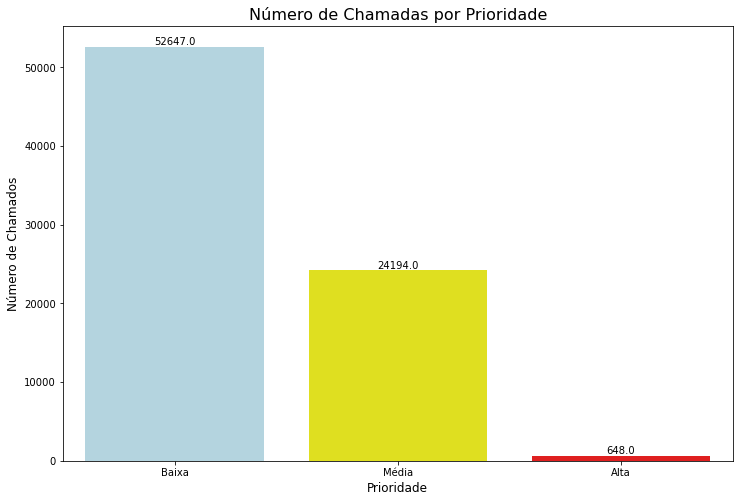

In [123]:
# Plot 
plt.figure(figsize=(12,8))

ax = sns.barplot(x = q3.Prioridade, y = q3.numero_chamadas, palette= ['lightblue', 'yellow', 'red'])
plt.title('Número de Chamadas por Prioridade', fontdict={'fontsize':16})
plt.xlabel('Prioridade', fontdict = {'fontsize': 12})
plt.ylabel('Número de Chamados', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()


# Questão 4

4.	Escreva duas queries em SQL que retornem: 

i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.

> filtro os ultimos três meses, agrupo por Prioridade, vejo a contagem e dividor pra ter semanalmente

In [124]:
query = "SELECT COUNT(*) AS numero_chamadas, WEEK(data) AS semana, Prioridade\
    FROM df4\
    WHERE data >= (SELECT MAX(data) from df4) - INTERVAL 3 MONTH\
    GROUP BY semana, Prioridade;"

Resultado da query acima


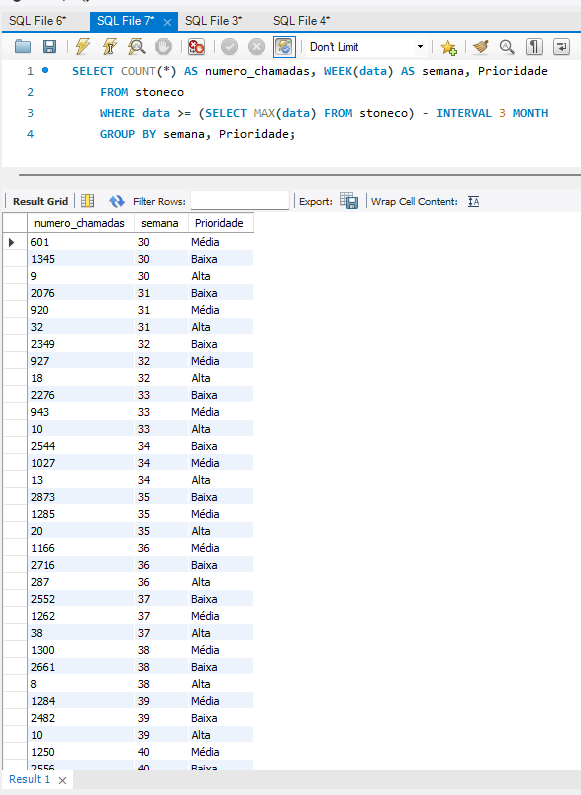

In [125]:
from IPython. display import Image
print('Resultado da query acima')
Image("query2.png")

ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias (por exemplo, para o dia 30/01, a query deve retornar a quantidade de chamados totais entre os dias 01/01 e 30/01)


In [126]:
query = "SELECT  data, COUNT(*), SUM(COUNT(*)) OVER (PARTITION BY DATE_FORMAT(data - INTERVAL 1 MONTH, '%m') ORDER BY data) AS soma FROM df4 GROUP BY data;"
query

"SELECT  data, COUNT(*), SUM(COUNT(*)) OVER (PARTITION BY DATE_FORMAT(data - INTERVAL 1 MONTH, '%m') ORDER BY data) AS soma FROM df4 GROUP BY data;"

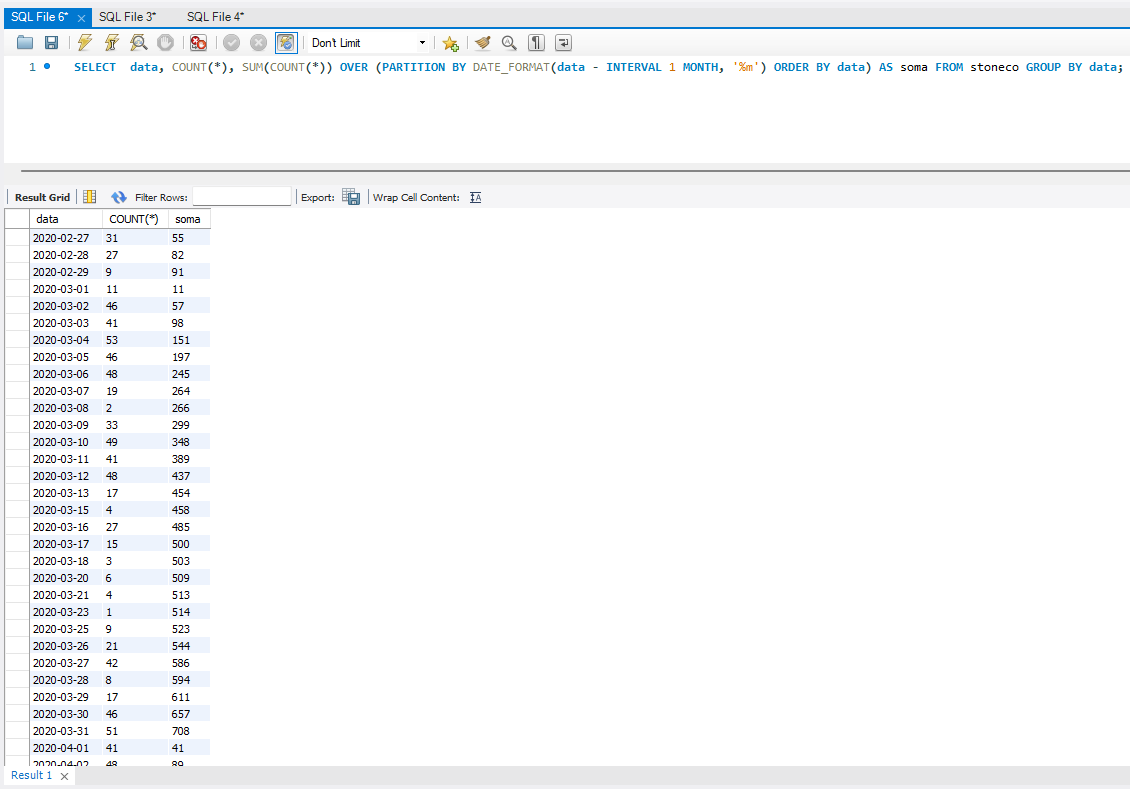

In [127]:
from IPython. display import Image
Image("query1.png")

# Questão 5

5.	Questão de estudo livre: Como é esperado de um analista de dados, traga insights relevantes sobre pontos de atenção e possíveis melhorias que você identificou ao analisar ambas as bases de dados. Além disso faça pelo menos duas perguntas relacionadas aos dados que julgue relevantes para análise, você também pode sugerir outros dados para enriquecer os aqui disponibilizados.

> Foi observado que nossa base de dados de chamadas contavam apenas com chamadas feitas via telefone. Seria interessante se pudessemos analisar chamadas feitas de por outros canais (e-mail, chat) para podermos enriquecer nossa análise comparando essas chamadas com a satisfação, tempo de espera, com o número de chamadas feitas após a mudança no site, etc.  
> Outro ponto que foi análisado durante a resolução das questões, foi que os clientes tendem a fazer mais chamados após sua primeira semana de credenciamento. Com base nessa análise, seria interessante enviar aos clientes recém credenciados um documento com as perguntas mais feitas por novos clientes (FAQ), dessa maneira poderíamos sanar possíveis dúvidas e consequentemente reduzir o número de chamadas.  
> Outro ponto notado durante a análise é que os número de chamadas não pareceram ter uma relação com o dia do mês.  
> Foi notado também que as chamdas com assuntos referentes a Produto, Aplicativo e Logística correspondem a cerca de , portanto seria interessante focar principalmente nesse tipo de dúvidas ao propor o FAQ proposto acima

i) A satisfação tende a ser mais positiva quando o cliente tem menor tempo de espera?

In [128]:
df5 = df4.copy()
df5.pesquisa_satisfacao.value_counts()

Sem_resposta    65904
Enviado          9996
Incrivel          899
Bom               425
Normal            112
NaoResolveu       107
Feliz              19
MalAtendido        16
Triste              6
Pessimo             3
Cansativo           2
Name: pesquisa_satisfacao, dtype: int64

In [129]:
# Vou criar uma nova coluna pra dividir a satisfação com positiva, neutra e negativa
df5['avaliacao'] = np.nan

for i in range(0, len(df5)):
    if df['pesquisa_satisfacao'][i] in (['Sem_resposta', 'Normal']):
        df5['avaliacao'][i] = 'Neutra'
    elif df['pesquisa_satisfacao'][i] in (['Cansativo', 'Pessimo', 'Triste', 'MalAtendido', 'NaoResolveu']):
        df5['avaliacao'][i] = 'Negativa'
    else:
        df5['avaliacao'][i] = 'Positiva'

In [130]:
q5 = df5.groupby('avaliacao').agg({'tempo_espera':'mean'})
q5

,tempo_espera
avaliacao,
Negativa,31.902985
Neutra,15.847658
Positiva,25.068877


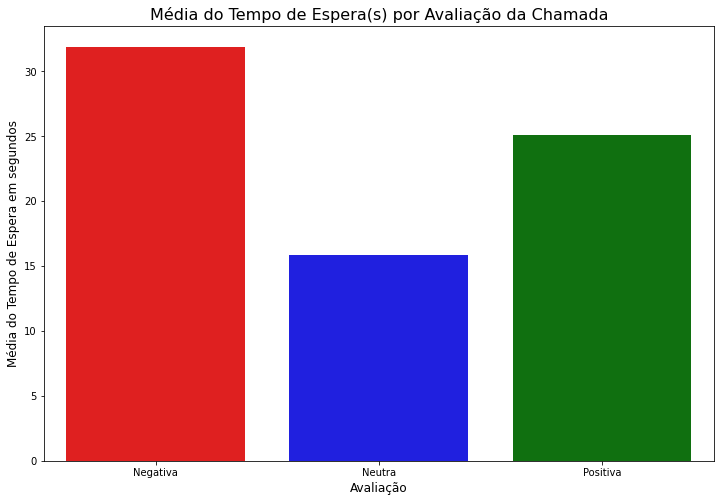

In [131]:
plt.figure(figsize=(12,8))

sns.barplot(x = q5.index, y = q5.tempo_espera, palette= ['red', 'blue', 'green'])
plt.title('Média do Tempo de Espera(s) por Avaliação da Chamada', fontdict={'fontsize':16})
plt.xlabel('Avaliação', fontdict = {'fontsize': 12})
plt.ylabel('Média do Tempo de Espera em segundos', fontdict = {'fontsize': 12})

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+ 200, round(p.get_height(), 2), horizontalalignment='center')
    
plt.show()

Clientes que deram um feedback negativo na avaliação foram em média clientes que tiveram maior tempo de espera. Pressupondo que o cliente ter uma boa experiência ao abrir uma chamada seja importante, seria válido investir para que consigamos diminuir o tempo de espera, diminuindo assim os feedbacks negativos.

ii) Quais regiões e cidades possuem maior número de entrega de maquininhas?

In [132]:
df6 = df2.copy()
df6


,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2019-07-24,Betim,MG,T1,0011L00002Wd777QAB
1,2019-07-24,Mossoró,RN,T1,0011L00002Wd78eQAB
2,2019-07-24,Rio de Janeiro,RJ,T1,0011L00002WdAxkQAF
3,2019-07-24,Maricá,RJ,NONE,0011L00002Wd7AkQAJ
4,2019-07-24,São Paulo,SP,T1,0011L00002Wd78PQAR
...,...,...,...,...,...
77484,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77485,2020-10-30,Placas,PA,T3,0013j000030SNX6AAO
77486,2020-10-30,Rio de Janeiro,RJ,T1,0013j000030FZxaAAG
77487,2020-10-30,Almirante Tamandaré,PR,T2,0013j00002yLMR1AAO


In [133]:
q6 = df6.groupby('endereco_entrega_estado').agg({'id_conta':'count'}).reset_index(drop=False).sort_values('id_conta', ascending = False)
q6.head(10)

,endereco_entrega_estado,id_conta
25,SP,20056
18,RJ,13266
10,MG,5215
4,BA,5143
17,PR,4144
15,PE,3644
5,CE,3443
23,SC,3038
8,GO,2667
22,RS,2261


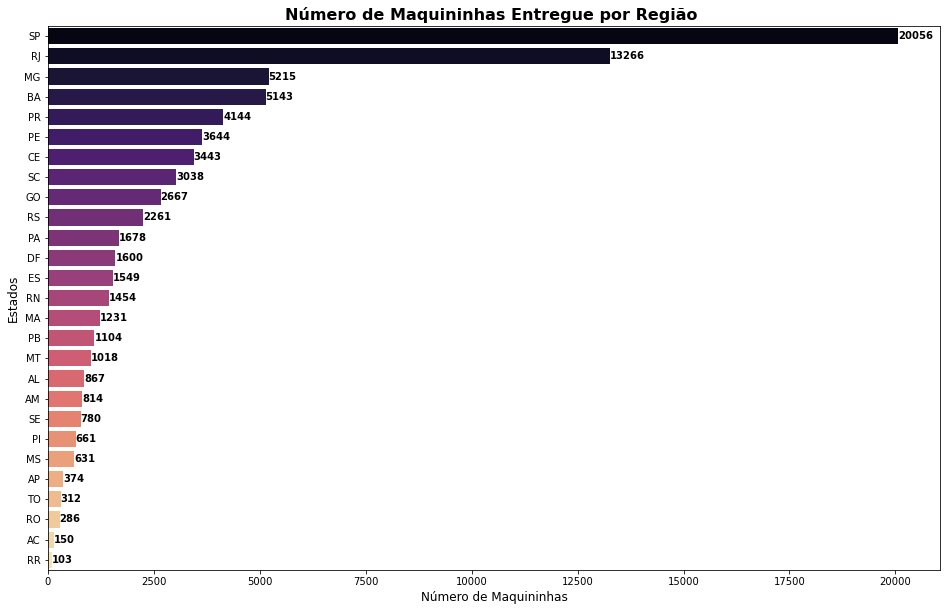

In [134]:
# Plot
plt.figure(figsize = (16,10))

ax = sns.barplot(data = q6, y = q6.endereco_entrega_estado, x = q6.id_conta, palette = 'magma', orient = 'h')
plt.title('Número de Maquininhas Entregue por Região ', fontdict = {'fontsize': 16}, weight = 'bold')
plt.xlabel('Número de Maquininhas', fontdict = {'fontsize': 12})
plt.ylabel('Estados', fontdict = {'fontsize': 12})



for i, (p, pr) in enumerate(zip(q6.endereco_entrega_estado, q6.id_conta)):

    # extract the rectangles from ax
    rectangle = ax.patches[i]
    
    # get the x for the bar
    x = rectangle.get_x()
    
    # get the width
    width = rectangle.get_width()
    
    # calculate the label position
    x_label = x + width
    
    # use the rectangle x to plot the text and set the ha to right instead of left
    plt.text(s=pr, x=x_label, y=i, color='black', va="center", ha="left", size=10, weight='bold')
    
    
plt.show()

In [135]:
q7 = df6.groupby('endereco_entrega_cidade').agg({'id_conta':'count'}).reset_index(drop=False).sort_values('id_conta', ascending = False)
q7.head()

,endereco_entrega_cidade,id_conta
2439,São Paulo,6389
2070,Rio de Janeiro,5401
2118,Salvador,2002
871,Fortaleza,1650
372,Brasília,1591


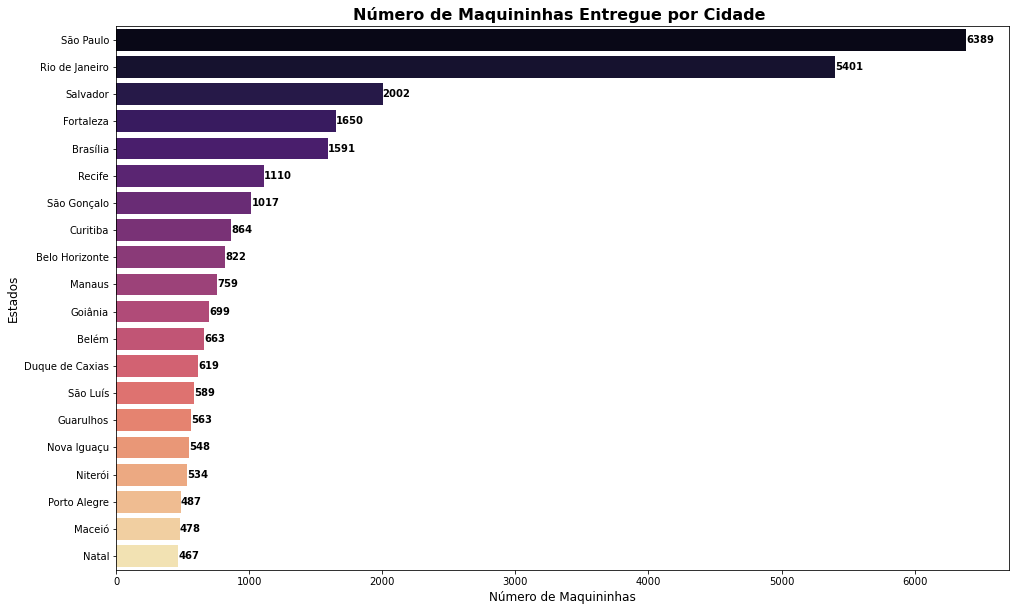

In [136]:
# Plot
plt.figure(figsize = (16,10))

ax = sns.barplot(data = q7, y = q7.endereco_entrega_cidade[:20], x = q7.id_conta, palette = 'magma', orient = 'h')
plt.title('Número de Maquininhas Entregue por Cidade ', fontdict = {'fontsize': 16}, weight = 'bold')
plt.xlabel('Número de Maquininhas', fontdict = {'fontsize': 12})
plt.ylabel('Estados', fontdict = {'fontsize': 12})

for i, (p, pr) in enumerate(zip(q7.endereco_entrega_cidade[:20], q7.id_conta[:20])):

    # extract the rectangles from ax
    rectangle = ax.patches[i]
    
    # get the x for the bar
    x = rectangle.get_x()
    
    # get the width
    width = rectangle.get_width()
    
    # calculate the label position
    x_label = x + width
    
    # use the rectangle x to plot the text and set the ha to right instead of left
    plt.text(s=pr, x=x_label, y=i, color='black', va="center", ha="left", size=10, weight='bold')
    
plt.show()

As cidades onde mais temos pedidos de maquininha é a capital São Paulo, seguido pelo Rio de Janeiro, Savlador, Fortaleza e Brasília.

Preciso saber o número de maquininha pedidos por cliente

In [137]:
q8 = df6.groupby(['id_conta','endereco_entrega_estado']).agg({'id_conta':'count'})
q8.columns = ['contador']
q8


,,contador
id_conta,endereco_entrega_estado,
0011L00002BkMyMQAV,MG,3
0011L00002Cj0AdQAJ,MG,2
0011L00002EIYHiQAP,SC,1
0011L00002EKxMcQAL,GO,3
0011L00002IXd2mQAD,SP,1
...,...,...
0013j000030SNX6AAO,PA,1
0014100001cPlR3AAK,SP,1
0014100001fNwQfAAK,SP,3


Número de clientes que contratam 5 ou mais maquininhas por Estado

In [138]:
q8 = q8[(q8['contador'] >= 5)].reset_index(drop = False).sort_values('contador')
q8 = q8.groupby('endereco_entrega_estado').agg({'id_conta':'count'}).sort_values('id_conta', ascending= False)
q8.head()

,id_conta
endereco_entrega_estado,
SP,953
RJ,682
BA,274
MG,266
PR,206


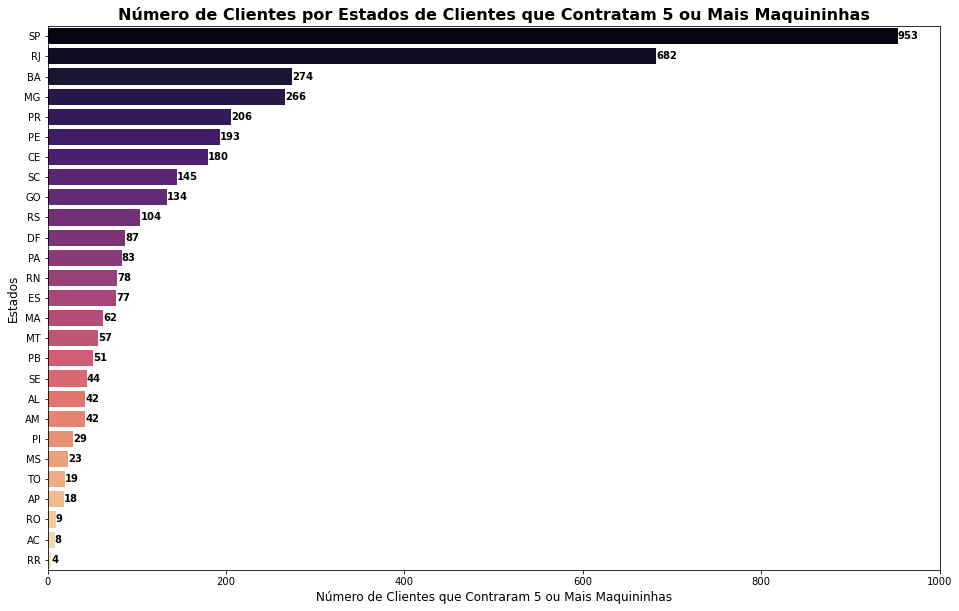

In [139]:
# Plot
plt.figure(figsize = (16,10))

ax = sns.barplot(data = q8, y = q8.index, x = q8.id_conta, palette = 'magma', orient = 'h')
plt.title('Número de Clientes por Estados de Clientes que Contratam 5 ou Mais Maquininhas', fontdict = {'fontsize': 16}, weight = 'bold')
plt.xlabel('Número de Clientes que Contraram 5 ou Mais Maquininhas', fontdict = {'fontsize': 12})
plt.ylabel('Estados', fontdict = {'fontsize': 12})

for i, (p, pr) in enumerate(zip(q8.index, q8.id_conta)):

    # extract the rectangles from ax
    rectangle = ax.patches[i]
    
    # get the x for the bar
    x = rectangle.get_x()
    
    # get the width
    width = rectangle.get_width()
    
    # calculate the label position
    x_label = x + width
    
    # use the rectangle x to plot the text and set the ha to right instead of left
    plt.text(s=pr, x=x_label, y=i, color='black', va="center", ha="left", size=10, weight='bold')
    
plt.show()

Aqui temos os estados que mais possuem clientes credenciados que pedem mais de 5 maquininhas pra uma região, ou seja, as regiões.  
Como conclusão a essa informação, podemos atribuir uma Prioridade maior para clientes da região de SP e RJ, que estão isolados, respectivamente, em primeiro e segundo lugar dos estados que país possuem clientes com entrega de 5 ou mais maquininhas, que tendem a ser clientes que trazem mais receita à empresa. Ou podemos até mesmo, marcar os clientes em específico que compram mais maquininhas como Prioridade Alta 